In [1]:
# Enrico Borriello 
# Sept 1, 2023

#Fitting the scaling of the average control kernel

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # interactive 3D plots
from scipy.optimize import curve_fit # non-linear fit

In [5]:
data = pd.read_csv('CK_vs_entropy_data_scan.csv')
data = data.drop('elapsed_time', axis=1)
data = data.drop('seed', axis=1)

In [6]:
# average over network topologies with same n, r, and eta
averaged_data = pd.DataFrame(data.groupby(['n','r','eta'])['ck_mean_size'].mean())
averaged_data = averaged_data.reset_index()
# Add log2(r) and difference
averaged_data['log2(r)'] = np.log2(averaged_data['r'])
averaged_data['difference'] = averaged_data['ck_mean_size'] - averaged_data['log2(r)']
#averaged_data.head()

In [5]:
#fig = px.scatter_3d(df, x='r', y='eta', z='difference')
#fig.update_layout(scene=dict(aspectmode='cube'))
#fig.update_traces(marker={'size': 3}) 
#fig.show()

### Fit at fixed n

In [89]:
def func(r_eta, A, B, r0, eta0):
    # it needs to be function of a single variable
    # one way around it is to have r_eta = (r,eta)
    r, eta = np.array(r_eta)
    return A + B/((r+r0)*(eta+eta0)**2)

In [102]:
def func_exp(r_eta, C, D, r1, eta1):
    r, eta = np.array(r_eta)
    return C + D*np.exp(-r/abs(r1) - eta/abs(eta1))

**Model 1:** For fixed size of the network, $n$,

$$  \left< |CK| \right> - \log_2(r) = A + \frac{B}{(r+r_0)(\eta+\eta_0)^2}   $$

with $r =$ number of attractors and $\eta =$ basin entropy.

**Model 2:** For fixed size of the network, $n$,

$$  \left< |CK| \right> - \log_2(r) = C + D e^{-r/r_1 - \eta/\eta_1}   $$

with $r =$ number of attractors and $\eta =$ basin entropy.

In [149]:
n = 8 #11

df = averaged_data[averaged_data.n == n]
df.head()

,n,r,eta,ck_mean_size,log2(r),difference
0,8,2,0.036875,2.300,1.0,1.300
1,8,2,0.065914,1.950,1.0,0.950
2,8,2,0.091983,2.075,1.0,1.075
3,8,2,0.116115,2.100,1.0,1.100
4,8,2,0.138800,2.200,1.0,1.200


In [150]:
r_data = list(df.r)
eta_data = list(df.eta)
difference_data = list(df.difference)

In [151]:
# Fit (Note: It doesn't converge without a starting point.)
popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,1000,10,1],maxfev = 10000)
popt_exp, pcov_exp = curve_fit(func_exp, (r_data, eta_data), difference_data, p0 = [1,1,10,1],maxfev = 10000)
print("Model 1 parameters: {}".format(popt))
print("Model 2 parameters: {}".format(popt_exp))

Model 1 parameters: [-6.37472135e-01  2.12872978e+03  3.85399738e+01  5.56721655e+00]
Model 2 parameters: [-0.5095699   1.59719626 41.59478671  3.02038203]


### Plots

In [11]:
import plotly.graph_objs as go

In [152]:
r_range = np.linspace(0, 100, 101)
eta_range = np.linspace(0, 10,11)
x, y = np.meshgrid(r_range, eta_range)
z = func((x, y), *popt)
z_exp = func_exp((x,y), *popt_exp)

In [153]:
fig = px.scatter_3d(df, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
fig.add_trace(surface_trace)
fig.show()

In [125]:
fig = px.scatter_3d(df, x='r', y='eta', z='difference')
fig.update_layout(scene=dict(aspectmode='cube'))

surface_trace = go.Surface(z=z_exp, x=x, y=y, showscale=False, opacity=0.5, colorscale='gray')
fig.update_traces(marker={'size': 4}) 

# Add the surface plot trace to the existing figure
fig.add_trace(surface_trace)
fig.show()

The data suggest that the fitting surface must have a peak at very low $r$. This is consistent with the fact that $\left< |CK| \right> - \log_2(r)$ must be zero at $r=1$. Modify the fitting function to account for that.

In [14]:
def RMSD (list1, list2):
    chi2 = np.mean((list2-list1)**2)
    RMSD = np.sqrt(chi2)
    return RMSD

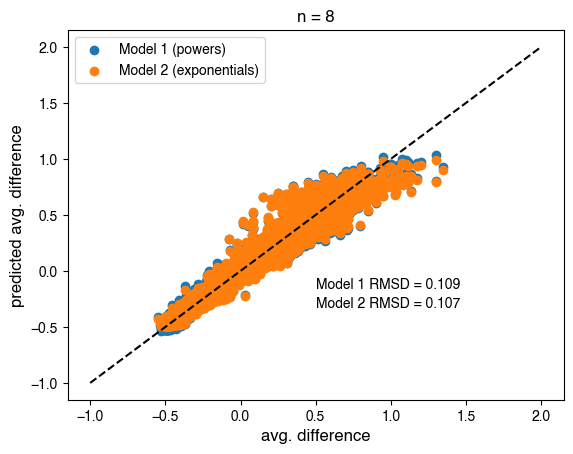

In [154]:
difference_pred = func((r_data, eta_data), *popt)
difference_pred_exp = func_exp((r_data, eta_data), *popt_exp)

plt.scatter(difference_data,difference_pred,label='Model 1 (powers)')
plt.scatter(difference_data,difference_pred_exp,label='Model 2 (exponentials)')
plt.plot([-1,2],[-1,2],'k--')
plt.xlabel('avg. difference',size=12)
plt.ylabel('predicted avg. difference',size=12)

rmsd = RMSD(difference_pred,difference_data)
rmsd_exp = RMSD(difference_pred_exp,difference_data)
plt.title('n = {}'.format(n))
plt.text(0.5,0.3,'Model 1 RMSD = {:.3f}'.format(rmsd),transform=plt.gca().transAxes)
plt.text(0.5,0.25,'Model 2 RMSD = {:.3f}'.format(rmsd_exp),transform=plt.gca().transAxes)
plt.legend()

plt.show()

### APPENDIX: Scaling with n

In [131]:
parameters,parameters_exp = [],[]
ns = [8,9,10,11]
for n in ns:
    df = averaged_data[averaged_data.n == n]
    r_data = list(df.r)
    eta_data = list(df.eta)
    difference_data = list(df.difference)
    popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,1000,10,1],maxfev = 10000)
    popt_exp, pcov_exp = curve_fit(func_exp, (r_data, eta_data), difference_data, p0 = [1,1,10,1],maxfev = 10000)
    parameters.append(popt)
    parameters_exp.append(popt_exp)
df_par = pd.DataFrame(parameters,columns = ['A','B','r0','eta0'],index=ns)
df_par_exp = pd.DataFrame(parameters_exp,columns = ['C','D','r1','eta1'],index=ns)

In [132]:
df_par

,A,B,r0,eta0
8,-0.637472,2128.729781,38.539974,5.567217
9,-0.800386,2559.231601,43.430372,5.348117
10,-0.944105,3705.839624,51.133412,5.716926
11,-1.005900,3654.545981,56.861661,5.185055


In [133]:
df_par_exp

,C,D,r1,eta1
8,-0.509570,1.597196,41.594787,3.020382
9,-0.648159,1.845806,48.531891,2.859493
10,-0.763073,1.986402,57.285866,2.946008
11,-0.817293,2.150304,64.005846,2.699195


In [134]:
# Assuming df is your DataFrame
average_df_par = df_par.mean()  # Calculate the average for each column
relative_change_df_par = (df_par - average_df_par) / average_df_par 

average_df_par_exp = df_par_exp.mean()  # Calculate the average for each column
relative_change_df_par_exp = (df_par_exp - average_df_par_exp) / average_df_par_exp

In [135]:
#relative_change_df_par['n'] = pd.DataFrame(range(8,12))
relative_change_df_par.reset_index(names=['n'],inplace=True)
relative_change_df_par_exp.reset_index(names=['n'],inplace=True)

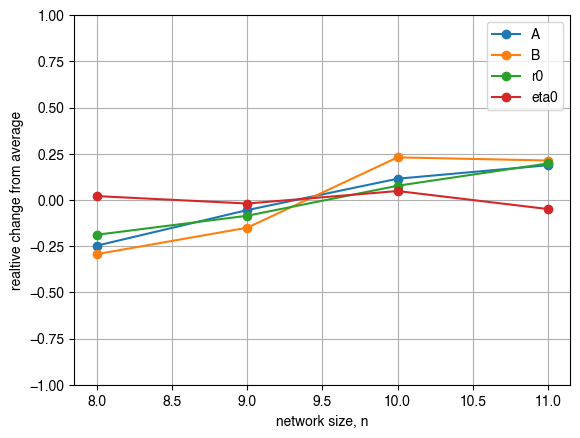

In [36]:
for column in ['A','B','r0','eta0']:
    plt.plot(relative_change_df_par['n'], relative_change_df_par[column], '-o',label=column)

plt.ylim(-1,1); plt.grid(True); plt.legend();
plt.xlabel('network size, n'); plt.ylabel('realtive change from average');

plt.show()

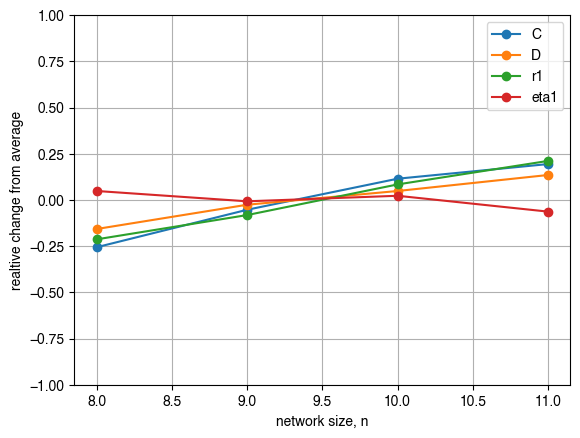

In [136]:
for column in ['C','D','r1','eta1']:
    plt.plot(relative_change_df_par_exp['n'], relative_change_df_par_exp[column], '-o',label=column)

plt.ylim(-1,1); plt.grid(True); plt.legend();
plt.xlabel('network size, n'); plt.ylabel('realtive change from average');

plt.show()

In [ ]:
# BCD 2023/9/14 
# What does small-r behavior look like as n increases?

In [21]:
# taken from entropy_and_basin_sizes.py

def min_basin_entropy(r,n):
    return (r-1)*n/2**n -(1-(r-1)/2**n)*np.log2((1-(r-1)/2**n))

def max_basin_entropy(r):
    """
    Note: This does not include a restriction due to having an
    integer number of states in each basin.  This could produce
    a bug in sampling near to the maximum entropy.
    """
    return np.log2(r)

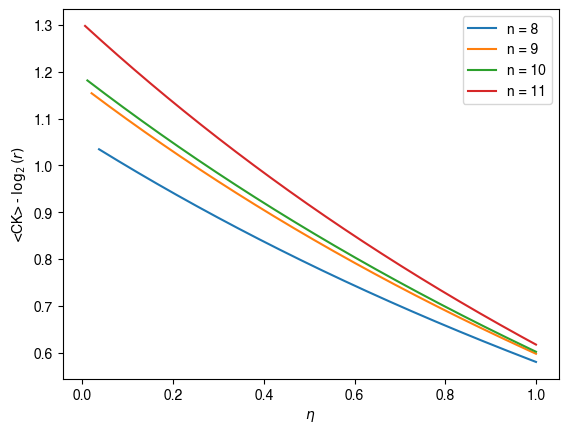

In [46]:
r = 2
for n in [8,9,10,11]:
    min_eta,max_eta = min_basin_entropy(r,n),max_basin_entropy(r)
    etas = np.linspace(min_eta,max_eta,1000)
    params = df_par.loc[n]
    A = params['A']
    B = params['B']
    r0 = params['r0']
    eta0 = params['eta0']
    predicted_diff = [ func((r,eta), A, B, r0, eta0) for eta in etas]
    plt.plot(etas,predicted_diff,label='n = {}'.format(n))
plt.xlabel('$\eta$')
plt.ylabel('<CK> - $\log_2(r)$')
plt.legend()

### APPENDIX: Fit with more parameters (alpha and beta)

In [20]:
# It doesn't work. Try this again after filling the gaps in the binning over r.

In [21]:
def func(r_eta, A, B, r0, eta0, alpha, beta):
    # it needs to be function of a single variable
    # one way around it is to have r_eta = (r,eta)
    r, eta = r_eta
    return A + B/( ((r+r0)**alpha) * ((eta+eta0)**beta)  )

In [22]:
r_data = list(df.r)
eta_data = list(df.eta)
difference_data = list(df.difference)

In [23]:
# Fit (Note: It doesn't converge without a starting point.)
popt, pcov = curve_fit(func, (r_data, eta_data), difference_data, p0 = [1,100,10,1,1,1])
print(popt)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.